# Fashion-MNIST Classification with an MDA Head
This notebook trains a small convolutional encoder with a mixture discriminant analysis (MDA) head 
on Fashion-MNIST, then evaluates calibration plots.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dnll import MDAHead, DNLLLoss


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)


device = cuda


### Data


In [3]:
tfm = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='./data', train=True, transform=tfm, download=True)
test_ds  = datasets.FashionMNIST(root='./data', train=False, transform=tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(test_ds)


(60000, 10000)

### Model: encoder + MDA head


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepMDA(nn.Module):
    def __init__(self, C, D, K):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = MDAHead(C, D, K)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot


model = DeepMDA(C=10, D=9, K=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = DNLLLoss(lambda_reg=1.0)

train_acc = []
test_acc = []

for epoch in range(1, 101):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    train_acc.append(tr_acc)
    test_acc.append(te_acc)
    print(f'[MDA {epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}')


[MDA 01] train loss=2.7997 acc=0.8034 | test acc=0.7676
[MDA 02] train loss=1.7155 acc=0.8925 | test acc=0.8423
[MDA 03] train loss=1.3313 acc=0.9141 | test acc=0.8887
[MDA 04] train loss=1.2410 acc=0.9289 | test acc=0.9081
[MDA 05] train loss=1.2092 acc=0.9371 | test acc=0.9204
[MDA 06] train loss=1.1858 acc=0.9452 | test acc=0.9131
[MDA 07] train loss=1.1642 acc=0.9526 | test acc=0.9143
[MDA 08] train loss=1.1515 acc=0.9579 | test acc=0.8979
[MDA 09] train loss=1.1340 acc=0.9639 | test acc=0.8889
[MDA 10] train loss=1.1214 acc=0.9684 | test acc=0.9031
[MDA 11] train loss=1.1052 acc=0.9746 | test acc=0.9198
[MDA 12] train loss=1.0914 acc=0.9802 | test acc=0.9251
[MDA 13] train loss=1.0779 acc=0.9846 | test acc=0.9268
[MDA 14] train loss=1.0677 acc=0.9881 | test acc=0.9246
[MDA 15] train loss=1.0616 acc=0.9899 | test acc=0.8762
[MDA 16] train loss=1.0481 acc=0.9941 | test acc=0.9205
[MDA 17] train loss=1.0422 acc=0.9955 | test acc=0.9081
[MDA 18] train loss=1.0341 acc=0.9972 | test acc

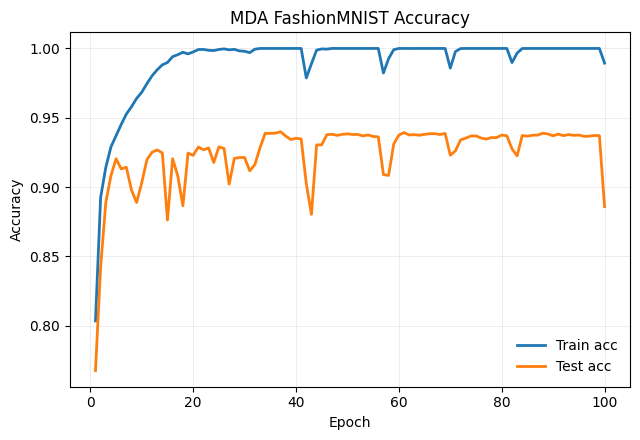

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(6.5, 4.5))
plt.plot(epochs, train_acc, label='Train acc', linewidth=2)
plt.plot(epochs, test_acc, label='Test acc', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MDA FashionMNIST Accuracy')
plt.legend(frameon=False)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()
